In [73]:
import pandas as pd
import numpy as np
from typing import Dict, Optional, Callable, List, Set
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
dfs = [train_df, test_df]

Transformer = Callable[[pd.DataFrame], None]
transformers_train: List[Transformer] = []
transformers_test: List[Transformer] = []

train_df

,Id,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,58170,165091278,84611205,Caucasian,Male,[30-40),?,Emergency,Discharged to home,Emergency Room,4,CP,?,61,0,9,0,1,0,250.12,382,490,4,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,>30
1,31114,100112946,23383485,AfricanAmerican,Female,[70-80),?,Urgent,Discharged to home,Physician Referral,4,?,InternalMedicine,43,0,13,0,0,0,486,428,401,4,None,None,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,<30
2,12129,49597686,29046960,Caucasian,Male,[50-60),?,Emergency,Discharged to home,Emergency Room,11,?,?,87,6,56,0,0,0,812,860,865,9,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
3,20601,72502314,59909715,Caucasian,Male,[70-80),?,NaN,Discharged to home,NaN,4,?,Family/GeneralPractice,44,0,17,0,0,1,491,550,574,5,None,None,Down,No,No,No,No,No,Down,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,>30
4,71793,208992156,57902751,Caucasian,Female,[50-60),?,Emergency,Discharged to home,Emergency Room,4,MC,?,47,0,19,0,0,2,250.6,536,530,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,<30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76319,91074,304378820,68613876,Caucasian,Female,[80-90),?,Emergency,Discharged/transferred to SNF,Emergency Room,4,MC,?,26,0,12,0,0,0,386,511,276,9,None,None,No,No,No,No,Steady,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,>30
76320,35174,109257300,10640943,Caucasian,Male,[60-70),?,Urgent,Discharged to home,Physician Referral,8,MC,Family/GeneralPractice,36,0,9,0,0,0,250.81,707,682,5,None,None,Up,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
76321,85075,269113782,66671397,Caucasian,Female,[70-80),?,Emergency,Discharged to home,Emergency Room,1,MC,?,38,0,12,0,0,0,530,496,278,9,None,>7,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
76322,5473,28445940,3099303,AfricanAmerican,Female,[60-70),?,Emergency,Discharged to home,Emergency Room,3,?,InternalMedicine,41,0,9,0,0,0,786,401,250,4,None,Norm,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO


In [74]:
def nanify_unknowns(df: pd.DataFrame, unknown = ['?', 'Unknown/Invalid', 'Other', 'Not Available', 'Not Mapped']):
    df.set_index("Id", inplace=True)
    df.drop(["encounter_id", "patient_nbr"], axis=1, inplace=True)
    for c in df.loc[:,df.dtypes == 'object']:
        df[c] = df[c].str.strip()
    df.replace(unknown, np.nan, inplace=True)

In [75]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV

In [76]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

def fit_ordinals_one_hot(df: pd.DataFrame) -> List[Transformer]:
    transformers: List[Transformer] = []

    def e_to_trans(encoder, columns: List[str]) -> Transformer:
        def wrapper(df: pd.DataFrame):
            df[columns] = encoder.transform(df[columns])
        return wrapper

    e_readmitted = OrdinalEncoder(categories=[['NO', '<30', '>30']], dtype=np.int8)
    e_readmitted.fit(df[['readmitted']])
    transformers.append(e_to_trans(e_readmitted, ['readmitted']))

    e_max_glu_serum = OrdinalEncoder(categories=[['None', 'Norm', '>200', '>300']], dtype=np.int8)
    e_max_glu_serum.fit(df[['max_glu_serum']])
    transformers.append(e_to_trans(e_max_glu_serum, ['max_glu_serum']))

    e_A1Cresult = OrdinalEncoder(categories=[['None', 'Norm', '>7', '>8']], dtype=np.int8)
    e_A1Cresult.fit(df[['A1Cresult']])
    transformers.append(e_to_trans(e_A1Cresult, ['A1Cresult']))

    e_change = OrdinalEncoder(categories=[['No', 'Ch']], dtype=np.int8)
    e_change.fit(df[['change']])
    transformers.append(e_to_trans(e_change, ['change']))

    e_diabetesMed = OrdinalEncoder(categories=[['Yes', 'No']], dtype=np.int8)
    e_diabetesMed.fit(df[['diabetesMed']])
    transformers.append(e_to_trans(e_diabetesMed, ['diabetesMed']))

    # No, Down, Steady, Up
    cols_ndsu = ["metformin",
    "repaglinide",
    "nateglinide",
    "chlorpropamide",
    "glimepiride",
    "acetohexamide",
    "glipizide",
    "glyburide",
    "tolbutamide",
    "pioglitazone",
    "rosiglitazone",
    "acarbose",
    "miglitol",
    "troglitazone",
    "tolazamide",
    "examide",
    "citoglipton",
    "insulin",
    "glyburide-metformin",
    "glipizide-metformin",
    "glimepiride-pioglitazone",
    "metformin-rosiglitazone",
    "metformin-pioglitazone",
    ]
    e_ndsu = OrdinalEncoder(categories=np.full((len(cols_ndsu), 4), ['No', 'Down', 'Steady', 'Up']).tolist(), dtype=np.int8)
    e_ndsu.fit(df[cols_ndsu])
    transformers.append(e_to_trans(e_ndsu, cols_ndsu))
    
    # one hot
    cols_onehot = ['race', 'admission_type_id', 'gender']
    for col in cols_onehot:
        def wrap(col: str):
            e_onehot = OneHotEncoder(handle_unknown='ignore')
            mask = df[col].notnull()
            e_onehot.fit(df.loc[mask, col].values.reshape(-1,1))
            def onehot_transformer(df: pd.DataFrame):
                df[e_onehot.get_feature_names_out()] = e_onehot.transform(df[col].values.reshape(-1,1)).toarray().astype(np.uint8)
                df.drop(columns=col, inplace=True)
            return onehot_transformer
        transformers.append(wrap(col))

    return transformers

In [77]:
def fit_ranges(df: pd.DataFrame) -> List[Transformer]:
    transformers: List[Transformer] = []
    cols = ['age', 'weight']

    def range_transformer(df: pd.DataFrame):
        def range_to_mean(s: str):
            return np.array(s[1:-1].split('-')).astype(np.int, copy=False).mean(0)

        for col in cols:
            mask = df[col].notnull()
            df.loc[mask, col] = df.loc[mask, col].apply(range_to_mean)
            df[col] = pd.to_numeric(df[col])

    transformers.append(range_transformer)

    return transformers


In [78]:
def fit_frequencies(df: pd.DataFrame) -> List[Transformer]:
    transformers: List[Transformer] = []

    cols = [
        "discharge_disposition_id",
        "admission_source_id",
        "payer_code",
        "medical_specialty",
        "diag_1",
        "diag_2",
        "diag_3"
    ]
    counts = {col: df[col].value_counts().to_dict() for col in cols}

    def frequency_transformer(df: pd.DataFrame) -> Transformer:
        for col in cols:
            mask = df[col].notnull()
            df.loc[mask, col] = df.loc[mask, col].apply(lambda v: counts[col].get(v, np.nan))
            df[col] = pd.to_numeric(df[col])

    transformers.append(frequency_transformer)
    return transformers

In [79]:
def print_objcets(df: pd.DataFrame):
    for c in df.loc[:,df.dtypes == 'object']:
        max_len = max(map(len, df[c].values.astype(str)))
        max_len = max(max_len, 15)
        apost = lambda s: f"'{s}'"
        counts = "\n".join([f"\t{apost(k):{max_len+3}}: {v}" for k, v in df[c].value_counts().to_dict().items()])
        print(f"Column \"{c}\":\n{counts}")

In [80]:
# preprocess dataframes and fit transformers

for df in test_df, train_df:
    nanify_unknowns(df)

transformers = fit_ordinals_one_hot(train_df)
transformers.extend(fit_ranges(train_df))
transformers.extend(fit_frequencies(train_df))

transformers_train = transformers
transformers_test = transformers[1:] # omit readmitted encoder
    

In [81]:
# apply transformers

for df, transformers in zip((test_df, train_df), (transformers_test, transformers_train)):
    for encoder in transformers:
        encoder(df)
    print_objcets(df)

In [82]:
# normalize

# inspect attributes distributions
# for col in train_df:
#     plt.hist(train_df[col], 20, density=True)
#     plt.title(col)
#     plt.show()

cols_std = [
    'age',
    'weight',
    'time_in_hospital',
    'payer_code',
    'num_lab_procedures',
    'num_medications'
]

cols_lin = test_df.columns.difference(cols_std)

scaler_std = StandardScaler()
scaler_std.fit(train_df[cols_std])

scaler_lin = MinMaxScaler()
scaler_lin.fit(train_df[cols_lin])

train_df[cols_std] = scaler_std.transform(train_df[cols_std])
test_df[cols_std] = scaler_std.transform(test_df[cols_std])

train_df[cols_lin] = scaler_lin.transform(train_df[cols_lin])
test_df[cols_lin] = scaler_lin.transform(test_df[cols_lin])


In [83]:
# impute
imputer = SimpleImputer()
imputer.fit(train_df.drop(columns='readmitted'))

cols = train_df.columns
train_df.loc[:,cols != 'readmitted'] = imputer.transform(train_df.drop(columns='readmitted'))
test_df.loc[:,:] = imputer.transform(test_df)

In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from math import inf

y = train_df['readmitted']
X = train_df.drop(columns='readmitted')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

class Model:
    def fit(*args, **kwags):
        raise NotImplementedError()
    def predict(*args, **kwags):
        raise NotImplementedError()

models: Dict[str, Model] = {
    "LogisticRegression": LogisticRegression(max_iter=inf),
    "DecisionTreeClassifier(max_depth=2)": DecisionTreeClassifier(max_depth=2),
    "DecisionTreeClassifier(max_depth=3)": DecisionTreeClassifier(max_depth=3),
    "DecisionTreeClassifier(max_depth=4)": DecisionTreeClassifier(max_depth=4),
    "DecisionTreeClassifier(max_depth=5)": DecisionTreeClassifier(max_depth=5),
}

for model in models.values():
    model.fit(X_train, y_train)

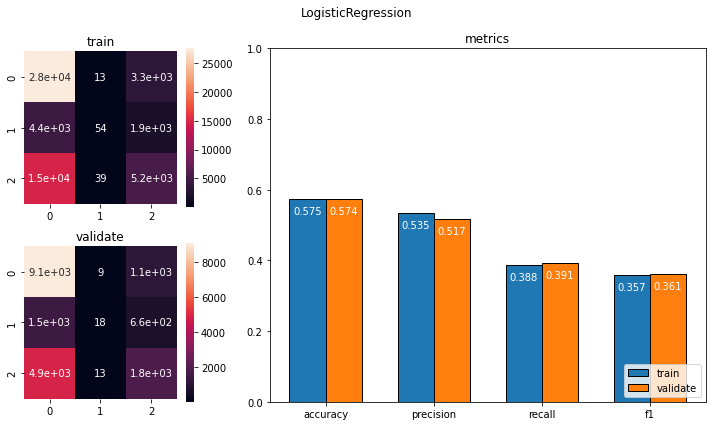

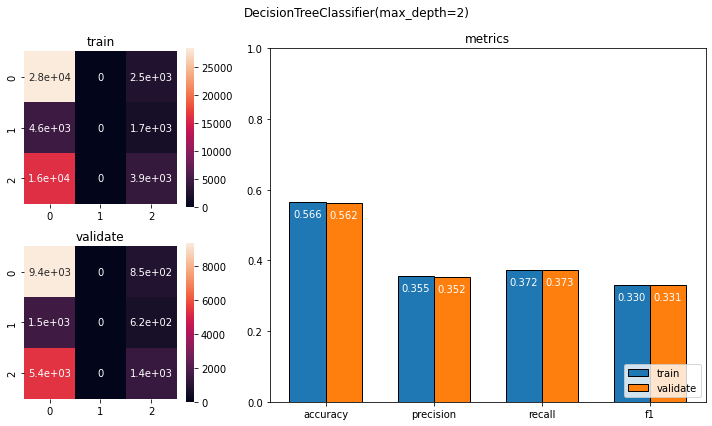

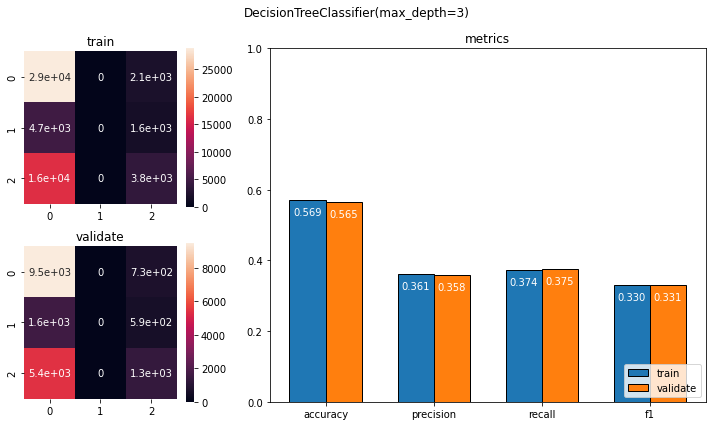

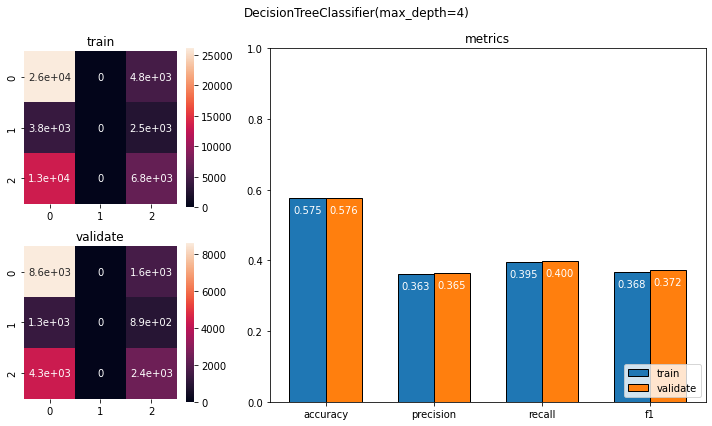

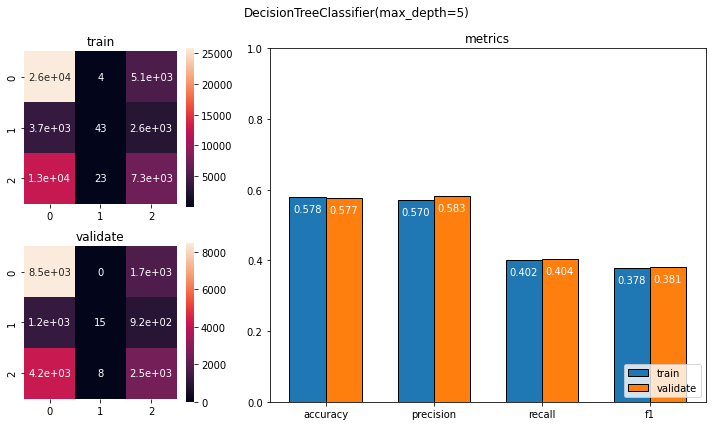

In [94]:
from evaluate import get_metrics, plot_model

for name, model in models.items():
    y_pred_train = model.predict(X_train)
    metrics_train, cm_train = get_metrics(y_train, y_pred_train)

    y_pred_val = model.predict(X_val)
    metrics_val, cm_val = get_metrics(y_val, y_pred_val)

    plot_model(
        (metrics_train, metrics_val),
        (cm_train, cm_val),
        ('train', 'validate'),
        name
    )
    plt.show()
